In [1]:
from keras.datasets import cifar100
import os
import sys
from six.moves import urllib
import gzip
import pickle
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

# Get Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
x_train = x_train / 255.0
x_test =  x_test / 255.0

Using TensorFlow backend.


In [2]:
# size of MNIST
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


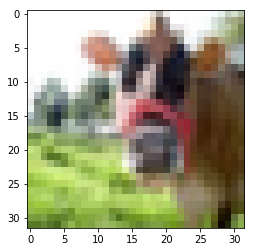

In [3]:
# # show data
_, (ax1) = plt.subplots(1)
sample_data = x_train[0]
ax1.imshow(sample_data, cmap=plt.cm.Greys)

In [4]:
def residual_block(x_input, num_filter, chg_dim):
    """
    input -> Conv -> BN -> ReLU -> Conv -> BN -> Addition -> ReLU -> output
    :param input_layer: Usually previous layer
    :param filter: (width<int>, height<int>) The size of the filter
    :param channel: [in_channels, out_channels]
    :param stride: The size of the s
    :return:
    """
    stride = 1
    
    # stride가 2일 경우
    if chg_dim:
        stride = 2
        pool1 = tf.layers.max_pooling2d(inputs= x_input, strides=2, pool_size=[2,2])
        pad1 = tf.pad(pool1, [[0,0],[0,0],[0,0],[int(num_filter/4),int(num_filter/4)]])
        shortcut = pad1
    else:
        shortcut = x_input
        
    b_n1 = tf.layers.batch_normalization(inputs = x_input)
    relu1 = tf.nn.relu(b_n1)
    conv1 = tf.layers.conv2d(inputs = relu1, 
                             filters = num_filter, 
                             kernel_size = [3,3], 
                             padding = "SAME",
                            strides=stride,
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
    b_n2 = tf.layers.batch_normalization(inputs = conv1)
    relu2 = tf.nn.relu(b_n2)
    conv2 = tf.layers.conv2d(inputs = relu2, filters=num_filter,
                            kernel_size=[3,3],
                            padding="SAME",
                            strides=1,
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
    x_output = conv2 + shortcut
    
    return x_output

In [5]:
def model(x, by):
    with tf.variable_scope('input_scope'):
        h = tf.layers.conv2d(inputs = x, filters = 64, kernel_size=[7,7], padding="SAME", strides=2)
        h = tf.layers.batch_normalization(inputs = h)
        h = tf.nn.relu(h)
    
    # Pooling layer
    h = tf.layers.max_pooling2d(inputs = h, strides = 2, pool_size=2)
        
    with tf.variable_scope('residual01'),tf.device('/device:GPU:0'):
        h = residual_block(h, 64, False)
        h = residual_block(h, 64, False)
        h = residual_block(h, 64, False)
        h = residual_block(h, 64, False)
        h = residual_block(h, 64, False)
        h = residual_block(h, 64, False)
        
    with tf.variable_scope('residual02'),tf.device('/device:GPU:0'):
        #h = tf.layers.max_pooling2d(inputs = h, strides = 2, pool_size=2)
        h = residual_block(h, 128, True)
        h = residual_block(h, 128, False)
        h = residual_block(h, 128, False)
        h = residual_block(h, 128, False)
        h = residual_block(h, 128, False)
        h = residual_block(h, 128, False)
        h = residual_block(h, 128, False)
        h = residual_block(h, 128, False)
        
    with tf.variable_scope('residual03'),tf.device('/device:GPU:0'):
        h = residual_block(h, 256, True)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
        h = residual_block(h, 256, False)
    
    with tf.variable_scope('residual04'),tf.device('/device:GPU:0'):
        h = residual_block(h, 512, True)
        h = residual_block(h, 512, False)
        h = residual_block(h, 512, False)
        h = residual_block(h, 512, False)
        h = residual_block(h, 512, False)
        h = residual_block(h, 512, False)
    

    # Average Pooling
    h = tf.reduce_mean(h, [1,2], keep_dims=True)
    h = tf.reshape(h,(-1, h.shape[1] * h.shape[2] * h.shape[3]))
    h = tf.layers.dense(h, 100)
    
    # One hot
    one_hot = tf.one_hot(by,100)
    one_hot = tf.reshape(one_hot, [-1, 100])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = h,
        labels= one_hot))
    opt = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(loss)
    softmax = tf.nn.softmax(h)
    preds = tf.argmax(softmax, axis=1)
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(one_hot,1), preds), tf.float32))
#     preds = tf.equal(tf.argmax(h,1),tf.argmax(one_hot,1))
#     acc = tf.reduce_mean(tf.cast(preds, tf.float32))
    init = tf.global_variables_initializer()
        
    return {
        'loss' : loss,
        'opt' : opt,
        'preds' : preds,
        'acc' : acc,
        'init' : init
    }

In [6]:
X = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
by = tf.placeholder(tf.int64)

resnet = model(X,by)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
num_epochs = 30
batch_size = 100
num_display = 100

with tf.Session() as sess:
    sess.run(resnet['init'])
    for ind_epoch in range(0, num_epochs):
        print('Current iteration {}'.format(ind_epoch + 1))

        for ind_ in range(0, int(50000 / batch_size)):
            batch_X = x_train[ind_*batch_size:(ind_+1)*batch_size]
            batch_by = y_train[ind_*batch_size:(ind_+1)*batch_size]
            _, cur_loss, cur_acc = sess.run(
                [resnet['opt'], resnet['loss'], resnet['acc']],
                feed_dict={X: batch_X, by: batch_by})
            if ind_ % num_display == 0:
                print('loss {0:.4f} acc {1:.4f}'.format(cur_loss, cur_acc))
    cur_acc_all = 0.0
    cur_loss_all = 0.0
    for ind_ in range(0, 10):
        cur_loss, cur_acc = sess.run(
                    [resnet['loss'], resnet['acc']],
                    feed_dict={X: x_test[ind_*1000:(ind_+1)*1000], 
                               by: y_test[ind_*1000:(ind_+1)*1000]})
        cur_loss_all += cur_loss
        cur_acc_all += cur_acc
    print('TEST: loss {0:.4f} acc {1:.4f}'.format(cur_loss_all / 10.0, 
                                                  cur_acc_all / 10.0))

Current iteration 1
loss 5.2764 acc 0.0100
loss 4.2790 acc 0.0300
loss 4.1513 acc 0.0300
loss 4.0081 acc 0.0800
loss 3.8777 acc 0.1000
Current iteration 2
loss 3.6917 acc 0.1200
loss 3.3579 acc 0.1600
loss 3.4063 acc 0.2100
loss 3.4252 acc 0.2400
loss 3.2867 acc 0.1300
Current iteration 3
loss 3.1931 acc 0.2200
loss 3.0180 acc 0.2400
loss 2.9097 acc 0.3000
loss 2.9083 acc 0.2900
loss 2.9049 acc 0.2700
Current iteration 4
loss 2.8356 acc 0.3000
loss 2.6191 acc 0.3200
loss 2.4321 acc 0.3400
loss 2.5241 acc 0.3500
loss 2.5878 acc 0.2800
Current iteration 5
loss 2.4573 acc 0.4000
loss 2.2506 acc 0.3600
loss 1.9144 acc 0.4400
loss 2.0215 acc 0.5000
loss 2.3708 acc 0.3400
Current iteration 6
loss 2.1771 acc 0.3900
loss 1.7872 acc 0.4200
loss 1.5774 acc 0.5600
loss 1.5519 acc 0.6100
loss 1.7230 acc 0.4900
Current iteration 7
loss 1.6863 acc 0.5100
loss 1.2534 acc 0.6000
loss 1.5475 acc 0.5500
loss 1.3635 acc 0.6600
loss 1.4190 acc 0.5700
Current iteration 8
loss 1.0602 acc 0.7200
loss 1.0654 